In [1]:
from os.path import join as pathjoin
from data_processing import *
from interpretation import *
from models import *
from training import *

In [2]:
DATA_DIR = '/home/mlepekhin/data'
MODELS_DIR = '/home/mlepekhin/models' 
MODEL_ID = 'allennlp_rubert'
#MODEL_ID = 'allennlp_rubert_base_cased_conversational'
CHECKPOINTS_DIR = pathjoin(MODELS_DIR, MODEL_ID, 'checkpoints')
BEST_MODEL = pathjoin(CHECKPOINTS_DIR, 'best.th')

In [3]:
transformer_model = 'DeepPavlov/rubert-base-cased'
#transformer_model = 'DeepPavlov/rubert-base-cased-conversational'
MAX_TOKENS = 512

### Loading of the pretrained model

In [4]:
vocab = Vocabulary().from_files(pathjoin(MODELS_DIR, MODEL_ID, 'vocab'))
model = build_transformer_model(vocab, transformer_model)

Building the model


In [5]:
id_to_label = vocab.get_index_to_token_vocabulary('labels')
print(id_to_label)
print(id_to_label.values())

{0: 'A8', 1: 'A12', 2: 'A1', 3: 'A14', 4: 'A11', 5: 'A17', 6: 'A16', 7: 'A4', 8: 'A9', 9: 'A7'}
dict_values(['A8', 'A12', 'A1', 'A14', 'A11', 'A17', 'A16', 'A4', 'A9', 'A7'])


In [6]:
if torch.cuda.is_available():
    cuda_device = 0
else:
    cuda_device = -1
print(cuda_device)
model.load_state_dict(torch.load(BEST_MODEL, map_location=f'cuda:{cuda_device}'))

0


<All keys matched successfully>

### Data loading

In [7]:
ru_test_df = pd.read_csv(pathjoin(DATA_DIR, 'ru_test'))
ru_test_df.head()

,Unnamed: 0,target,text
0,726,A7,Глава 1 Приступая к работе 1.1 Знакомство с те...
1,1871,A17,Kawasaki D-Tracker С недавних пор Kawasaki d-t...
2,1265,A17,"По моему , вполне достойные книги , может и не..."
3,205,A11,Тест-драйв Lada Granta : новая надежда автогра...
4,141,A8,"среда , 2 декабря 2009 года , 12.33 Бумага всё..."


In [8]:
true_classes = ru_test_df.target.values
sentences = ru_test_df.text.values

### Preliminary analysis

In [9]:
dataset_reader = build_transformer_dataset_reader(transformer_model, MAX_TOKENS)
predictor = TextClassifierPredictor(model, dataset_reader=dataset_reader)
predicted_classes = np.array(predict_classes(sentences, predictor, vocab))

In [10]:
print(type(predicted_classes == 'A1'))

<class 'numpy.ndarray'>


In [11]:
print(len(np.unique(true_classes)))

10


In [12]:
calc_classifier_metrics(predicted_classes, true_classes)

label (argum) f1_score 0.7080745341614907 precision 0.7402597402597403 recall 0.6785714285714286
label (fictive) f1_score 0.7999999999999999 precision 0.8695652173913043 recall 0.7407407407407407
label (instruct) f1_score 0.8275862068965517 precision 0.7058823529411765 recall 1.0
label (reporting) f1_score 0.9483568075117371 precision 0.9805825242718447 recall 0.9181818181818182
label (legal) f1_score 0.8148148148148148 precision 0.8461538461538461 recall 0.7857142857142857
label (personal) f1_score 0.6516853932584269 precision 0.5918367346938775 recall 0.725
label (commercial) f1_score 0.9467455621301775 precision 0.9411764705882353 recall 0.9523809523809523
label (research) f1_score 0.8627450980392157 precision 0.8979591836734694 recall 0.8301886792452831
label (info) f1_score 0.4680851063829786 precision 0.3333333333333333 recall 0.7857142857142857
label (eval) f1_score 0.6582278481012658 precision 0.7647058823529411 recall 0.5777777777777777
accuracy 0.8095238095238095


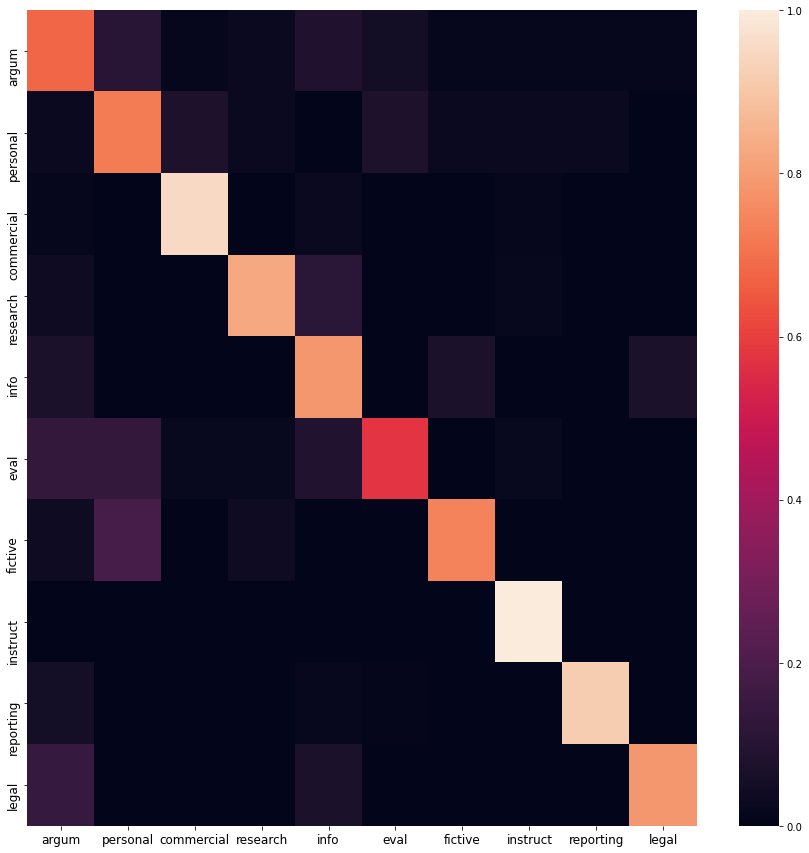

In [13]:
plot_confusion_matrix(predicted_classes, true_classes)

### Saliency Gradient Interpretation

In [14]:
smooth_grad = SmoothGradient(predictor)
simple_grad = SimpleGradient(predictor)
integrated_grad = IntegratedGradient(predictor)

In [15]:
mistake_ids = []

for sent_id in range(len(true_classes)):
    if true_classes[sent_id] != predicted_classes[sent_id]:
        mistake_ids.append(sent_id)

In [16]:
interpret_sentence(
    sentences[mistake_ids[0]], dataset_reader.tokenizer, 50, 
    [smooth_grad, simple_grad, integrated_grad],
    label_description[true_classes[mistake_ids[0]]],
    label_description[predicted_classes[mistake_ids[0]]]
)

TRUE LABEL: personal
LABEL: eval
<class 'allennlp.interpret.saliency_interpreters.smooth_gradient.SmoothGradient'> TEXT:
тест - дра ##ив la ##da gran ##ta : новая надежда авто ##града фактически , новая la ##da gran ##ta - это старая la ##da ka ##lin ##a плюс 400 новых дет ##але ##и . но назвать грант ##у всего лишь рест ##аи ##лингом калин ##ы язык не поверн ##ется . автомобиль деи ##ств ##ительно изменился и на самом деле стал лучше прежних продуктов автов ##аза . но поч ##ивать на лав ##рах тольят ##тин ##цам еще рано . ko ##les ##a . r u выяснили , почему . сюрприз ##ы поджид ##али еще до проб ##но ##и поездки на la ##da gran ##ta . провод ##ив меня к машине , сотрудник автос ##алона объяснил мне как пользоваться бр ##ел ##ком дополнительно ##и сигнализации : " если нажать на эту кнопку и немного подерж ##ать , двигатель завед ##ется ! " нажим ##ает . держит . не заводит ##ся . " наверное это из - за вашего коллеги , котор ##ы ##и открыл заднюю дверь , пока я жал на кнопку " . двер

In [17]:
interpret_sentence(
    sentences[mistake_ids[1]], dataset_reader.tokenizer, 50, 
    [smooth_grad, simple_grad, integrated_grad],
    label_description[true_classes[mistake_ids[1]]],
    label_description[predicted_classes[mistake_ids[1]]]
)

TRUE LABEL: personal
LABEL: eval
<class 'allennlp.interpret.saliency_interpreters.smooth_gradient.SmoothGradient'> TEXT:
я хотел бы рассказать немного о том , что мне нравится писать . я люблю погруж ##аться в тему , о котор ##ои пишу . мне нравится окун ##уться в тему с голово ##и и почувствовать себя таким подоп ##ыт ##ным кролик ##ом . я рассматрив ##аю свою жизнь как ряд экспериментов . ит ##ак , я работа ##ю в журнале es ##quir ##e , и пару лет назад я написал статью под названием " аутсор ##синг в мое ##и жизни " ; я нанял группу люд ##еи в банг ##ало ##ре , инди ##я , чтобы они прожили мою жизнь за меня . и они просматр ##ивали за меня мою электронную почту и отвечали на письма . они отвечали на мои телефонные звонки . они спор ##или вместо меня с мое ##и жен ##ои и читали моему сыну сказки на ночь . это был луч ##ши ##и месяц мое ##и жизни , потому что я просто сидел , читал книги и смотрел фильмы . это был чудес ##ны ##и опыт . позже , я написал для es ##quir ##e статью - - о 

In [18]:
interpret_sentence(
    sentences[mistake_ids[2]], dataset_reader.tokenizer, 50, 
    [smooth_grad, simple_grad, integrated_grad],
    label_description[true_classes[mistake_ids[2]]],
    label_description[predicted_classes[mistake_ids[2]]]
)

TRUE LABEL: research
LABEL: argum
<class 'allennlp.interpret.saliency_interpreters.smooth_gradient.SmoothGradient'> TEXT:
когда мы смотри ##м новости , мы видим сообщения из ирак ##а , афган ##истана , с ##ьерра - ле ##оне , и кажется , что эти конфликты невозможно понять . именно так я и думал , когда начинал этот проект . но я физик , и поэтому решил на ##ити данные и попробовать разобраться . просто попробовать . ну и как на ##ив ##ны ##и новозеланд ##ец я подумал , что по ##иду в пента ##гон . не могли бы вы поделиться со мн ##ои информ ##аци ##еи ? ( смех ) нет . поэтому пришлось задуматься пос ##ерьез ##нее . и вот однажды вечером в оксфорд ##е я смотрел новости . и обратил внимание на экран под говоря ##щи ##ми головами . и обнаружил там информацию . там были данные , в ль ##ющихся на нас потока ##х новост ##еи . весь шум вокруг нас деи ##ств ##ительно содержит информацию . и мне пришла в голову мысль организовать нечто вроде разведки по открытым источникам . если ском ##бин ##и

In [20]:
for label in id_to_label.values():
    print(label_description[label])
    print('=' * 100)
    cur_dataset = get_dataset_by_confusion_pair(
        sentences, label, label, true_classes, predicted_classes
    )
    words = get_most_frequent_trigger_words(cur_dataset, dataset_reader.tokenizer, 50, simple_grad)
    print(words[:50])

reporting
[('.', 441), (',', 131), ('[SEP]', 95), ('[CLS]', 94), ('"', 73), ('в', 71), ('-', 70), ('заявил', 56), ('##и', 55), ('росс', 40), ('президент', 32), ('##а', 27), ('##ии', 26), ('/', 23), ('р', 23), ('и', 23), ('сказал', 20), ('что', 19), ('сш', 19), ('по', 17), ('<', 17), ('москв', 17), ('на', 16), ('>', 16), (':', 16), ('он', 15), ('##ои', 15), ('года', 14), ('этом', 14), ('не', 14), ('##ф', 14), ('с', 13), ('как', 13), ('##p', 13), ('сообщил', 13), ('##ев', 13), ('сообщает', 13), ('словам', 12), ('украин', 12), ('медвед', 12), ('«', 11), ('ga', 11), ('новости', 11), ('напомним', 11), ('александр', 11), ('»', 10), ('об', 10), ('виктор', 10), ('2008', 10), ('##ны', 10)]
commercial
[('.', 333), ('[SEP]', 77), (',', 70), ('[CLS]', 68), ('-', 40), (':', 33), ('в', 33), ('##и', 31), ('не', 30), ('"', 24), ('и', 24), ('для', 21), ('мы', 17), ('позволяет', 16), ('##ои', 15), (')', 15), ('вам', 14), ('(', 14), ('вы', 13), ('!', 13), ('/', 12), ('это', 12), ('удоб', 10), ('с', 10), 

In [21]:
for label in id_to_label.values():
    print(label_description[label])
    print('=' * 100)
    cur_dataset = get_dataset_by_confusion_pair(
        sentences, label, label, true_classes, predicted_classes
    )
    words = get_most_frequent_trigger_words(cur_dataset, dataset_reader.tokenizer, 50, smooth_grad)
    print(words[:50])

reporting
[('.', 339), (',', 143), ('[SEP]', 71), ('"', 71), ('[CLS]', 56), ('заявил', 55), ('росс', 47), ('-', 40), ('в', 36), ('президент', 34), ('##и', 31), ('##ии', 25), ('##ф', 22), ('сш', 22), (':', 21), ('/', 19), ('москв', 17), ('сегодня', 15), ('и', 15), ('по', 15), ('сказал', 15), ('медвед', 15), ('р', 14), ('этом', 13), ('что', 13), ('>', 13), ('новости', 13), ('##еи', 13), ('президента', 13), ('александр', 12), ('сообщил', 12), ('напомним', 12), ('сообщает', 11), ('также', 11), ('##p', 11), ('не', 11), ('<', 11), ('россия', 11), ('словам', 10), ('ga', 10), ('пресс', 10), ('глава', 10), ('млрд', 10), ('сер', 10), ('##ои', 10), ('на', 9), ('апреля', 9), ('европ', 9), ('отметил', 9), ('виктор', 9)]
commercial
[('.', 214), ('[SEP]', 65), (',', 64), ('[CLS]', 48), ('-', 25), ('"', 21), ('##и', 20), (':', 19), ('мы', 18), ('не', 15), ('и', 14), ('!', 13), ('в', 12), ('очень', 12), ('благодаря', 11), ('вам', 11), ('люб', 10), ('это', 9), ('компания', 9), ('обеспечивает', 8), ('мож

In [ ]:
for label in id_to_label.values():
    print(label_description[label])
    print('=' * 100)
    cur_dataset = get_dataset_by_confusion_pair(
        sentences, label, label, true_classes, predicted_classes
    )
    words = get_most_frequent_trigger_words(cur_dataset, dataset_reader.tokenizer, 50, integrated_grad)
    print(words[:50])

reporting
